In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the validation dataset
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

24.5%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%
100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
len(train_dataset), len(val_dataset)

(60000, 10000)

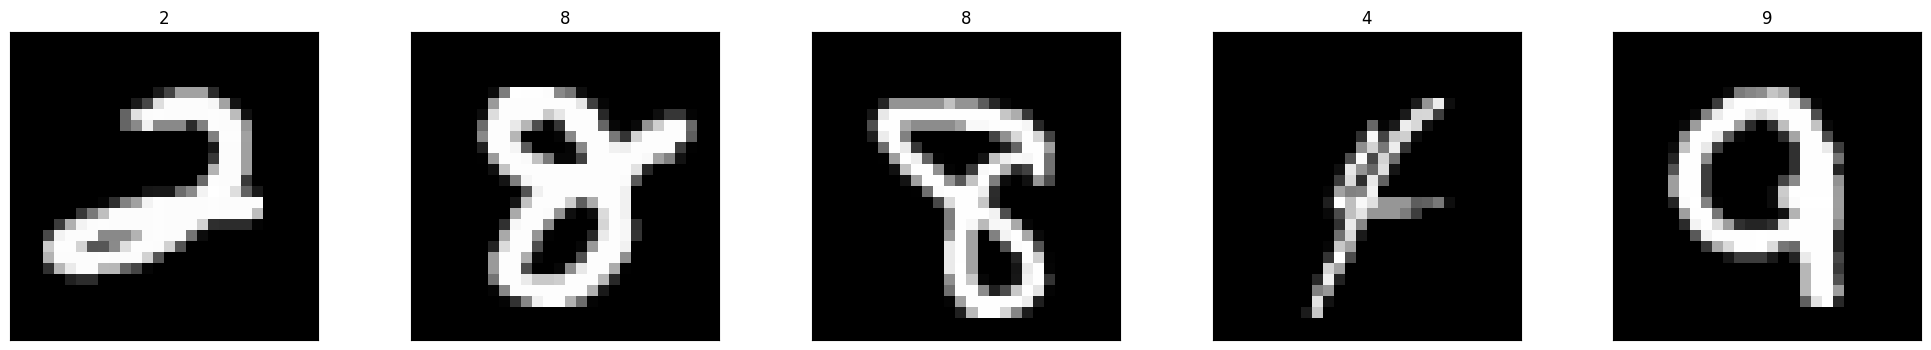

In [6]:
# Show the first 5 images with their labels
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 4))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.set_title(str(labels[idx].item()))

In [12]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [13]:
# Deefine the autoencoder network
class Net(nn.Module):
    """
    Autoencoder network
    """
    def __init__(self):
        super().__init__()
        # Encoder layer
        self.encoder = Encoder()
        # Decoder layer
        self.decoder = Decoder()
        

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        # Decoder
        x = self.decoder(x)
        return x
    
    def generate(self, x):
        # Generate images from latent space
        return self.decoder(x)
        
    
model = Net()

# Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

TypeError: Encoder.__init__() missing 2 required positional arguments: 'encoded_space_dim' and 'fc2_input_dim'

In [10]:
# Train the network
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        # Forward pass, backward pass, optimize
        print(data.shape)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))
            
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
            .format(epoch+1, num_epochs, running_loss/len(train_loader), (correct/total)*100))
    
# Save the model
torch.save(model.state_dict(), 'model.ckpt')

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

KeyboardInterrupt: 

In [7]:
# Save the model
torch.save(model.state_dict(), './models/mnist_cnn.pt')

In [8]:
# Evaluate the model on the validation dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in val_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on validation data: {accuracy:.2f}%')

Accuracy on validation data: 99.24%


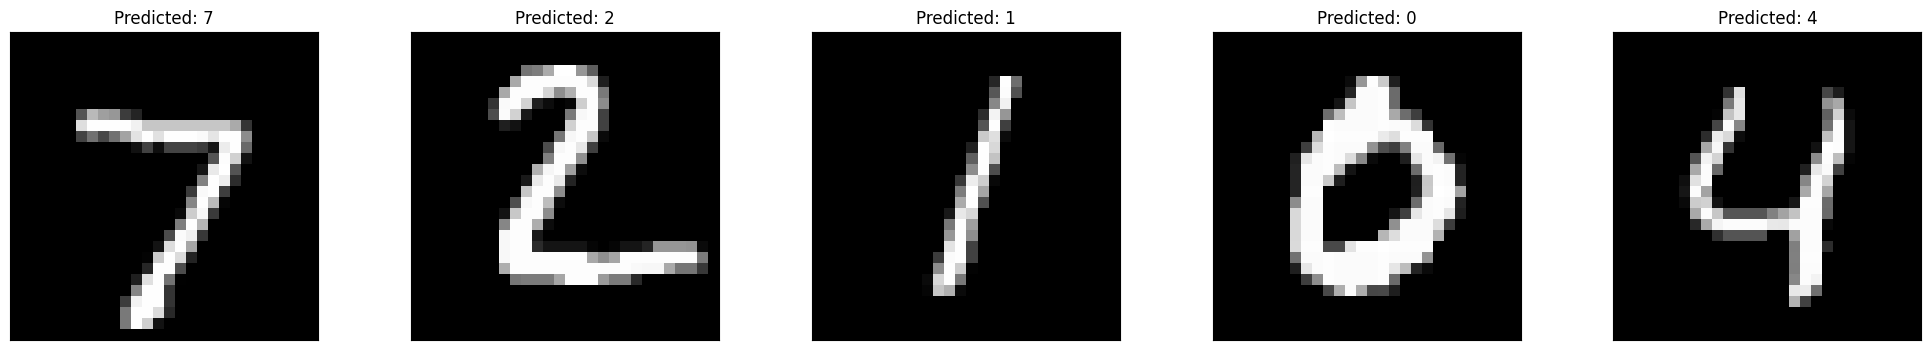

In [11]:
# Get a batch of images from the validation dataset
images, labels = next(iter(val_loader))

# Make predictions on the batch of images
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot the images with their predicted labels
fig = plt.figure(figsize=(25, 4))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.set_title(f'Predicted: {predicted[idx].item()}')

In [21]:
from sympy import symbols, div

# Define the variable and polynomial f(u)
u = symbols('u')
f_u = u**3 + 3*u - 2

# Define the given element (2u^2 + u - 3)(3u^2 - 4u + 1)
element = (u**2-u+4)*(u/6+1/6)

quotient, remainder = div(element, f_u, domain='QQ')

In [22]:
quotient, remainder

(1/6, 1)

In [16]:
mul

NameError: name 'mul' is not defined